#Q1

## 1. Stochastic and Gaussian Processes

**Stochastic Processes:**  
A stochastic process is a collection of random variables $\{X_t: t \in T\}$ indexed by a set $T$ (such as time or space). Each $X_t$ represents the state of a system at the index $t$.

**Gaussian Processes (GPs):**  
A Gaussian Process is a special kind of stochastic process where any finite subset of the process is jointly normally distributed. It is fully characterized by a mean function $m(x)$ and a covariance (kernel) function $k(x,x')$, expressed as:
$$
f(x) \sim \mathrm{GP}\bigl(m(x),\, k(x,x')\bigr).
$$
For any finite set of inputs $\{x_1, \dots, x_n\}$, the function values follow a joint normal distribution:
$$
\bigl(f(x_1), \dots, f(x_n)\bigr) \sim \mathcal{N}\bigl(\mathbf{m},\, \mathbf{K}\bigr),
$$
where $\mathbf{m} = \bigl[m(x_1), \dots, m(x_n)\bigr]^T$ and the covariance matrix $\mathbf{K}$ has entries $K_{ij} = k(x_i, x_j)$.

## 2. Variational Inference and the ELBO

**Objective:**  
In Bayesian inference, we aim to compute the posterior $p(\theta \mid X)$, but this is often intractable. Variational Inference (VI) approximates the posterior by introducing a simpler, tractable distribution $q(\theta)$.

**KL Divergence:**  
The discrepancy between the variational approximation $q(\theta)$ and the true posterior $p(\theta \mid X)$ is quantified using the Kullback-Leibler (KL) divergence:
$$
\mathrm{KL}\bigl(q(\theta) \parallel p(\theta \mid X)\bigr).
$$

**Evidence Lower Bound (ELBO):**  
Rather than directly minimizing the KL divergence, VI maximizes the Evidence Lower Bound (ELBO), defined as:
$$
\mathrm{ELBO}(q) = \mathbb{E}_{q(\theta)}\bigl[\log p(X, \theta)\bigr] - \mathbb{E}_{q(\theta)}\bigl[\log q(\theta)\bigr].
$$
Maximizing the ELBO serves two main purposes:
- The term $\mathbb{E}_{q(\theta)}\bigl[\log p(X, \theta)\bigr]$ rewards choices of $\theta$ that explain the observed data well.
- The term $\mathbb{E}_{q(\theta)}\bigl[\log q(\theta)\bigr]$ acts as a regularizer, penalizing overly complex approximations and thus balancing model complexity.

**Interpretation:**  
By maximizing the ELBO, we indirectly minimize the KL divergence between $q(\theta)$ and the true posterior $p(\theta \mid X)$, leading to a practical approximation of the posterior distribution. This balance between data fit and model simplicity is central to modern Bayesian inference methods.


/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [length_scale, amplitude, noise]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f_pred]


KeyError: 'f_pred'

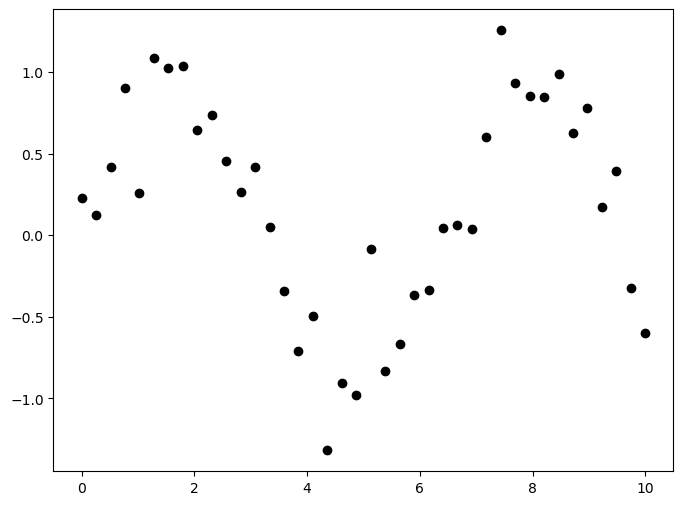

In [1]:
#Q2
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Simulate a dataset: 1D input (e.g., location) and noisy observations (e.g., house prices)
X = np.linspace(0, 10, 40)[:, None]   # 40 data points
y = np.sin(X).ravel() + 0.25 * np.random.randn(40)  # Sine function with added Gaussian noise

with pm.Model() as gp_model:
    # Define hyperparameters with prior distributions
    length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
    amplitude = pm.HalfNormal("amplitude", sigma=1)
    
    # Define the covariance function (kernel)
    kernel = amplitude**2 * pm.gp.cov.ExpQuad(1, length_scale)
    
    # Construct the GP marginal model
    gp = pm.gp.Marginal(cov_func=kernel)
    noise = pm.HalfNormal("noise", sigma=0.5)
    
    # Define the likelihood for observed data
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=noise)
    
    # Draw samples from the posterior
    trace = pm.sample(1000, chains=2, progressbar=True)
    
    # Generate new inputs for prediction
    X_new = np.linspace(0, 10, 100)[:, None]
    # Obtain the conditional GP for new inputs
    f_pred = gp.conditional("f_pred", X_new)
    # Sample from the posterior predictive distribution
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], model=gp_model)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color="black", label="Observed Data")
plt.plot(X_new, pred_samples["f_pred"].mean(axis=0), color="blue", label="Posterior Mean")
plt.fill_between(
    X_new.ravel(),
    np.percentile(pred_samples["f_pred"], 5, axis=0),
    np.percentile(pred_samples["f_pred"], 95, axis=0),
    color="blue",
    alpha=0.3,
    label="90% Credible Interval"
)
plt.xlabel("Input X")
plt.ylabel("Output y")
plt.title("GP Regression: Posterior Predictive")
plt.legend()
plt.show()

Finished [100%]: Average Loss = 93.327


array([[<Axes: title={'center': 'W1'}>, <Axes: title={'center': 'W1'}>],
       [<Axes: title={'center': 'W2'}>, <Axes: title={'center': 'W2'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>]],
      dtype=object)

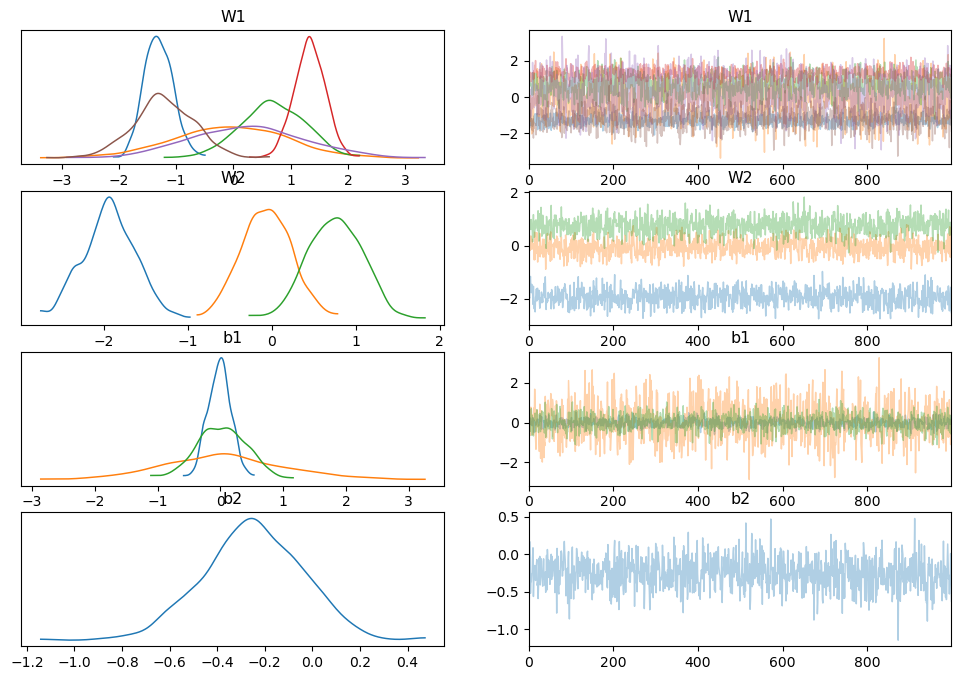

In [5]:
#Q3
import pymc as pm
import numpy as np
import pytensor.tensor as at
import matplotlib.pyplot as plt

# 1. Generate synthetic binary classification data
np.random.seed(42)
N = 200
X = np.random.randn(N, 2)  # 2D input features
true_weights = np.array([1.5, -2.0])
linear_combination = X.dot(true_weights)
probabilities = 1 / (1 + np.exp(-linear_combination))
y = np.random.binomial(1, probabilities)

# 2. Define the Bayesian neural network model
with pm.Model() as bnn_model:
    # Hidden layer size
    n_hidden = 3

    # Priors for weights and biases (input -> hidden)
    W1 = pm.Normal("W1", mu=0, sigma=1, shape=(2, n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))
    
    # Priors for weights and bias (hidden -> output)
    W2 = pm.Normal("W2", mu=0, sigma=1, shape=(n_hidden,))
    b2 = pm.Normal("b2", mu=0, sigma=1)
    
    # Neural network: one hidden layer with tanh activation
    hidden_layer = pm.math.tanh(at.dot(X, W1) + b1)
    logits = at.dot(hidden_layer, W2) + b2
    
    # Likelihood: Bernoulli with logit link
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y)
    
    # 3. Variational Inference (ADVI) with a chosen optimizer
    #    Valid 'method' options: 'advi', 'fullrank_advi', 'asvgd', 'svgd'
    approx = pm.fit(
        n=5000,
        method="advi",  
        obj_optimizer=pm.adagrad_window(learning_rate=0.01)
    )
    trace = approx.sample(draws=1000)

# 4. Posterior analysis
import arviz as az
az.plot_trace(trace)

